# Predict students' graduation rate

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ellacharmed/mlzoomcamp-midterms-predict-graduation/submission?labpath=notebook_model_tuning.ipynb)

- [dataset from @ roycekimmons.com](http://roycekimmons.com/tools/generated_data/graduation_rate)

> This is a fictional dataset and should only be used for data science training purposes.
> 
> This data set includes graduation rates from a four-year college with a variety of student factors.

The key questions we want to address:

> 1. How effective are entrance requirements at predicting gpa and graduation rate?
> 1. What would be the best way to improve graduation rates?

> All data sets are generated on-the-fly. So, you can increase your n by downloading a data set multiple times and combining the files. (n=1000) per large sample download

Based on the above statement, I have downloaded 5x times and combined them into one csv file so that we can work with a larger sample size of 5000 observations, instead of just 1000 observations.

Target is `'graduate_in_5years'` and column named simply as `'target'`
- feature-engineered from 'years_to_graduate' as 
  - 0: 'Yes' ie 'years_to_graduate' <= 5
  - 1: 'No' ie 'years_to_graduate' > 5 
- was set to 4 years initially until EDA reveals median is 5.


In [67]:
import sys
from pathlib import Path
import logging
from contextlib import redirect_stdout

# Configure the logging library.
logging.basicConfig(filename='randomizedcv_tuning.log', level=logging.INFO)

# Set the path to the current file
current_file_path = Path().resolve()
print(f'{current_file_path = } ')
        
# Set the path to the data folder
data_folder_path = current_file_path / 'data' 
print(f'{data_folder_path = } ')

# Set the path to the src folder
src_folder_path = current_file_path / 'src'
print(f'{src_folder_path = } ')

# Add the src folder to the system path
sys.path.append(str(src_folder_path))

# Import modules from files under /src
from src.config import * 
from src.data_loader import CSVDataLoader
from src.data_preprocessor import Preprocessor
from src.data_feature_builder import FeatureBuilder
from src.modeler import Trainer

current_file_path = WindowsPath('B:/repos/Courses/DataTalksClub/mlzoomcamp-midterms') 
data_folder_path = WindowsPath('B:/repos/Courses/DataTalksClub/mlzoomcamp-midterms/data') 
src_folder_path = WindowsPath('B:/repos/Courses/DataTalksClub/mlzoomcamp-midterms/src') 


## Import packages

In [68]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

In [69]:
# not supported for HistGradientBoostingClassifier & CatBoostClassifier
# from sklearnex import patch_sklearn
# patch_sklearn()

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier

import catboost
from catboost import *
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer, confusion_matrix, ConfusionMatrixDisplay, classification_report


In [70]:
import sklearn
sklearn.__version__

'1.3.1'

## Overview

> do we want 
> - 2 splits for train, test or 
> - 3 splits for train, val and test?
>
> reminder: 
> - not yet stratify
> - not scaled
> - use cross-validation 
> - save final df to file as processed_df.csv?

In this notebook, we're finally going to address the above questions. We're using 
- KFolds to cross-validate our data splitting,
- using just 3 features that were shown as the most important features via EDA
- scale our data, treat outliers ~~using Pipelines~~,
- perform hyperparameters tuning on the 2 classifiers with highest `'val auc'` scores,
- finally, the final chosen "best model" would be identified, and 
- creating scripts out of our POC code would commenced, and that would allow
- save our model to a `.pkl` file for us to deploy model to a web servic.e


## Hyperparameters Tuning

### Putting it all together

Based on findings from baseline scoring, we're gonna limit our GridSearch and hyperparameters tuning to just these 2 classifiers.

Perform data preprocessing and use pipelines to perform hyperparameter tuning to a couple of the models from previous top 2 performers:

- HistGradientBoostingClassifier()
- CatBoostClassifier()


In [50]:
scores = []

### test source



In [71]:
def rebuild_df():
    # Data ingestion
    data = CSVDataLoader().load(data_folder_path / 'graduation_rate.csv')
    print("- Preprocessor()...")
    data = Preprocessor().ColumnsSymbolReplacer(data)
    # display(f'{data.iloc[0:1] = }')
    # display(f'{data.iloc[11:12] = }')
    # display(data.head(2))
    data = Preprocessor().SymbolReplacer(
        data, 'parental_level_of_education')
    # display(data.head(2))
    data = Preprocessor().ColumnsDropper(data, TO_DROP)
    # display(data.head(2))
    print("- FeatureBuilder()...")
    data = FeatureBuilder().Target_encoder(data)
    # display(data.head(2))
    print("  -- Split TARGET_NAME for y...")
    target = data[TARGET_NAME]
    print("  -- Dropping TARGET_NAME...")
    data = data.drop(columns=TARGET_NAME)
    # display(data.head(2))
    print()
    print("  -- Set COLS_CATEGORICAL astype(category)...")
    data[COLS_CATEGORICAL] = data[COLS_CATEGORICAL].astype('category')
    # display(data.head(2))
    data = Preprocessor().DataScaler(data)
    # display(data.head(2))

    df_full_train, df_test, y_full_train, y_test = train_test_split(
        data, target, test_size=0.2, random_state=123)

    # reset indices back to begin from 0
    df_full_train = df_full_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    y_full_train = y_full_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    return df_full_train, df_test, y_full_train, y_test


In [52]:
df_full_train, df_test, y_full_train, y_test = rebuild_df()
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, test_size=0.25, random_state=123)
df_full_train.head()

Loading CSV data...


100%|██████████| 20/20 [00:00<00:00, 266.55it/s]

Finished processing the CSV file.
df.shape = (10000, 7)
- Preprocessor()...
  -- Replacing symbols in column names...
  -- Replacing symbols in data...
  -- Dropping TO_DROP columns...
- FeatureBuilder()...
  -- Creating 'target' column...
  -- Split TARGET_NAME for y...
  -- Dropping TARGET_NAME...

  -- Set COLS_CATEGORICAL astype(category)...
  -- Scaling columns with MinMaxScaler()...
  -- Scaling columns with RobustScaler()...


,parental_level_of_education,sat_total_score,parental_income,college_gpa
0,some high school,0.535433,-0.788048,0.600000
1,high school,0.769685,0.103235,0.666667
2,bachelors degree,0.652559,0.858316,0.666667
3,some high school,0.506890,-0.664158,0.600000
4,some high school,0.828740,0.042354,0.466667


### HistGradientBoostingClassifier Hyperparams Tuning 

#### setup



In [72]:
# AUC is not a defined scoring metric for RandomizedSearchCV
scoring = {
    "AUC": make_scorer(roc_auc_score), 
    "Accuracy": make_scorer(accuracy_score), 
    "F1": make_scorer(f1_score),
    "Precision": make_scorer(precision_score), 
    "Recall": make_scorer(recall_score)}

# custom_loss=['Accuracy', 'AUC:hints=skip_train~false', 'F1','Precision', 'Recall']

In [54]:
# Create a k-fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

hist_param_grid = {
    # 'classifier__loss': 'log_loss',                        # defaults, same as catboost's loss_function
    # 'classifier__categorical_features': COLS_CATEGORICAL,  # defaults, same as catboost's cat_features
    'learning_rate': LEARNING_RATE,    # defaults=0.1, 1=no shrinkage
    'max_iter': MAX_ITER,         # defaults=100; max num iterations/trees
    'max_depth': MAX_DEPTH,          # defaults=None; max depth of each tree
    'max_leaf_nodes': MAX_LEAF_NODES,    # defaults=31;max num of leaves
    'min_samples_leaf': MIN_SAMPLES_LEAF,  # defaults=20; min num of samples per leaf
    'early_stopping': ['auto', True],       # defaults='auto'; enabled for sample-size > 10000, else enabled when True
    'class_weight': WEIGHTS
}

In [55]:
# Create the model
model = HistGradientBoostingClassifier(
    # verbose=2, 
    # scoring='roc_auc', 
    warm_start=True,            # defaults=False
    random_state=42             # defaults=None                          
)
    
# Create a RandomizedSearchCV object
rnd_search = RandomizedSearchCV(
    estimator=model, 
    param_distributions=hist_param_grid, 
    cv=kfold, 
    # n_iter=10,                     # defaults
    # random_state=None,             # also has this here, or use in Classifier()           
    scoring=scoring,                 # to replace defaults 'loss'
    refit="AUC",                     # defaults='loss'
    error_score='raise', 
    return_train_score=True,
    verbose=2,
    n_jobs=-1
)


In [56]:
# Fit the pipeline to the train data and perform hyperparameter tuning
for train_idx, val_idx in tqdm(
                            kfold.split(df_full_train, 
                                        y_full_train), 
                            total=kfold.get_n_splits(), 
                            desc="k-fold"): 
        
    dv, X_train = Trainer().X_vectorizer(df_full_train.iloc[train_idx])
    y_train = y_full_train.iloc[train_idx].values

    logging.info('Fitting randomized_search model...')
    # Train the model on the train data
    rnd_search.fit(X_train, y_train)
    
logging.info('hyperparam with randomized_search fit completed')   

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


k-fold:  20%|██        | 1/5 [00:07<00:28,  7.07s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


k-fold:  40%|████      | 2/5 [00:13<00:20,  6.94s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


k-fold:  60%|██████    | 3/5 [00:19<00:12,  6.35s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


k-fold:  80%|████████  | 4/5 [00:25<00:06,  6.13s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


k-fold: 100%|██████████| 5/5 [00:30<00:00,  6.19s/it]


In [57]:
# Log the results of the tuning process.
logging.info('Finished HistGradientBoostingClassifier hyperparam tuning. The best hyperparameters are: {}'.format(rnd_search.best_params_))

# Print the best hyperparameters
best_params = rnd_search.best_params_
print(best_params)
    
# GridSearchCV took approx 45mins on my machine! 
# RandomizedSearchCV took approx 15s on my machine! 

{'min_samples_leaf': 5, 'max_leaf_nodes': 10, 'max_iter': 1000, 'max_depth': 6, 'learning_rate': 0.1, 'early_stopping': True, 'class_weight': 'balanced'}


#### predict

In [58]:
df_full_train, df_test, y_full_train, y_test = rebuild_df()
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, test_size=0.25, random_state=123)

dv, X_train = Trainer().X_vectorizer(df_train)
clf = HistGradientBoostingClassifier(**best_params)
clf.fit(X_train, y_train)

# Make predictions on the validate data
y_predprob_train, y_pred_train  = Trainer().y_predictor(df_train, dv, clf)
y_predprob_val, y_pred_val  = Trainer().y_predictor(df_val, dv, clf)

# compile the scores in a list
scores.append({
    "model": "HistGradientBoostingClassifier",
    "train auc": roc_auc_score(y_train, y_pred_train),
    "val auc": roc_auc_score(y_val, y_pred_val),
    "accuracy": accuracy_score(y_val, y_pred_val),
    "precision": precision_score(y_val, y_pred_val),
    "f1_mean": f1_score(y_val, y_pred_val),
    "recall": recall_score(y_val, y_pred_val),   
    }
)
logging.info(f'-- HistGradientBoostingClassifier val scores appended --')


Loading CSV data...


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 266.56it/s]


Finished processing the CSV file.
df.shape = (10000, 7)
- Preprocessor()...
  -- Replacing symbols in column names...
  -- Replacing symbols in data...
  -- Dropping TO_DROP columns...
- FeatureBuilder()...
  -- Creating 'target' column...
  -- Split TARGET_NAME for y...
  -- Dropping TARGET_NAME...

  -- Set COLS_CATEGORICAL astype(category)...
  -- Scaling columns with MinMaxScaler()...
  -- Scaling columns with RobustScaler()...


#### Best model AUC scores using validation data

In [59]:
print(f"The best set of parameters is: {rnd_search.best_params_}")
print()
print(f"train auc: {roc_auc_score(y_train, y_pred_train)}")
print(f"val auc: {roc_auc_score(y_val, y_pred_val)}")


The best set of parameters is: {'min_samples_leaf': 5, 'max_leaf_nodes': 10, 'max_iter': 1000, 'max_depth': 6, 'learning_rate': 0.1, 'early_stopping': True, 'class_weight': 'balanced'}

train auc: 0.6723225187677815
val auc: 0.638179364495154


#### evaluate (rnd_search.cv_results_)



In [ ]:
# [source](https://inria.github.io/scikit-learn-mooc/python_scripts/parameter_tuning_parallel_plot.html) for `shorten_param` code snippet

# def shorten_param(param_name):
#     if "param_" in param_name:
#         return param_name.rsplit("param_", 1)[1]
#     return param_name

# # [source](https://stackoverflow.com/a/73766566) for `clean_key(key)` code snippet
# pattern_list = ['param_', 'split']
# def clean_key(key):
#     for pattern in pattern_list:
#         key = key.replace(pattern, "")
#     return key
# {clean_key(k) :  v for k, v in x.items()}

In [60]:
cv_results = rnd_search.cv_results_

In [ ]:
# cv_results = cv_results.rename(shorten_param, axis=1)

#### plot

FIXME

In [ ]:
# from matplotlib import pyplot as plt
# plt.figure(figsize=(13, 13))
# plt.title("RandomizedSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

# plt.xlabel("max_iter")
# plt.ylabel("Score")

# ax = plt.gca()
# # ax.set_xlim(0.001, 10)
# # ax.set_ylim(0.2, 0.8)

# # Get the regular numpy array from the MaskedArray
# X_axis = np.array(cv_results["max_iter"], dtype=float)

# for scorer, color in zip(sorted(scoring), ["g", "k"]):
#     for sample, style in (("train", "--"), ("test", "-")):
#         sample_score_mean = cv_results["mean_%s_%s" % (sample, scorer)]
#         sample_score_std = cv_results["std_%s_%s" % (sample, scorer)]
#         ax.fill_between(
#             X_axis,
#             sample_score_mean - sample_score_std,
#             sample_score_mean + sample_score_std,
#             alpha=0.1 if sample == "test" else 0,
#             color=color,
#         )
#         ax.plot(
#             X_axis,
#             sample_score_mean,
#             style,
#             color=color,
#             alpha=1 if sample == "test" else 0.7,
#             label="%s (%s)" % (scorer, sample),
#         )

#     best_index =rnd_search.best_index_
#     best_score = cv_results["mean_test_%s" % scorer][best_index]

#     # Plot a dotted vertical line at the best score for that scorer marked by x
#     ax.plot(
#         [
#             X_axis[best_index],
#         ]
#         * 2,
#         [0, best_score],
#         linestyle="-.",
#         color=color,
#         marker="x",
#         markeredgewidth=3,
#         ms=8,
#     )

#     # Annotate the best score for that scorer
#     ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

# plt.legend(loc="best")
# plt.grid(False)
# plt.show()

In [ ]:
# import plotly.express as px
# import pandas as pd

# df = pd.DataFrame({
#     "learning_rate": cv_results["learning_rate"],
#     "mean_train_AUC": cv_results["mean_train_AUC"],
#     "mean_test_AUC": cv_results["mean_test_AUC"]
# })

# fig = px.line(df, x="learning_rate", y=["mean_train_AUC", "mean_test_AUC"], title="RandomizedSearchCV evaluating using multiple scorers simultaneously")
# fig.update_layout(
#     xaxis_title="learning_rate",
#     yaxis_title="Score",
#     legend_title="Scorer"
# )
# fig.show()

In [61]:
# Displaying a Pipeline with a Preprocessing Step and Regression
from sklearn import set_config
set_config(display="diagram")

rnd_search

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   error_score='raise',
                   estimator=HistGradientBoostingClassifier(random_state=42,
                                                            warm_start=True),
                   n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'early_stopping': ['auto', True],
                                        'learning_rate': [0.001, 0.01, 0.1,
                                                          1.0],
                                        'max_depth': [2, 6, 8, 12],
                                        'max_iter': [100, 500, 1000],
                                        'max_leaf_nodes': [2, 5, 10],
                                        'min_samples_leaf': [2, 5, 10]},
                   refit='AUC', return_train_score=True,
                   scoring={'AUC': make_scorer(roc_auc_score),
                            'Accuracy': make_scorer(accuracy_score),
                            'F1': make_scorer(f1_score),
                            'Precision': make_scorer(precision_score),
                            'Recall': make_scorer(recall_score)},
                   verbose=2)

#### current run's best_params

In [62]:
best_params = rnd_search.best_params_
best_params

{'min_samples_leaf': 5,
 'max_leaf_nodes': 10,
 'max_iter': 1000,
 'max_depth': 6,
 'learning_rate': 0.1,
 'early_stopping': True,
 'class_weight': 'balanced'}

best_params of previous runs

{'min_samples_leaf': 5, 
 'max_leaf_nodes': 5, 
 'max_iter': 100, 
 'max_depth': 6, 
 'learning_rate': 0.01, 
 'early_stopping': 'auto', 
 'class_weight': 'balanced'}

{'min_samples_leaf': 2,
 'max_leaf_nodes': 5,
 'max_iter': 500,
 'max_depth': 12,
 'learning_rate': 0.01,
 'early_stopping': 'auto',
 'class_weight': 'balanced'}

Due to RandomSearchCV, best params is always changing, but the val auc is constantly similar +-std0.005 miniscule amount

#### Evaluate test data with best params

In [63]:
# Make predictions on the test data
y_predprob_test, y_pred_test  = Trainer().y_predictor(df_test, dv, clf)

# compile the scores in a list
scores.append({
    "model": "HistGradientBoostingClassifier",
    "train auc": roc_auc_score(y_train, y_pred_train),
    "test auc": roc_auc_score(y_test, y_pred_test),
    "accuracy": accuracy_score(y_test, y_pred_test),
    "precision": precision_score(y_test, y_pred_test, zero_division=0.0),
    "f1_mean": f1_score(y_test, y_pred_test),
    "recall": recall_score(y_test, y_pred_test),   
    }
)
logging.info(f'-- HistGradientBoostingClassifier test scores appended --')

print(f"train auc: {roc_auc_score(y_train, y_pred_train)}")
print(f"val auc: {roc_auc_score(y_val, y_pred_val)}")
print(f"test auc: {roc_auc_score(y_test, y_pred_test)}")


train auc: 0.6723225187677815
val auc: 0.638179364495154
test auc: 0.6165522501906942


Insights:

Our AUC values do not deviate much from train set to val set to test set, so I feel we have a stable model with these set of `best_params`.

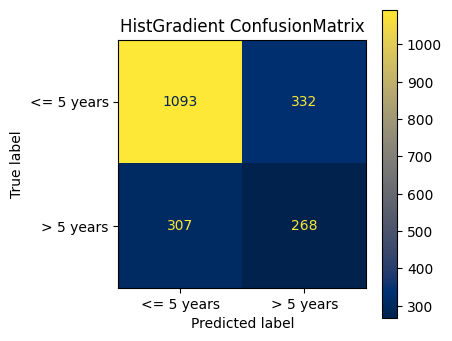

In [64]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4,4))
cm = confusion_matrix(y_test, y_pred_test)
cm_hist = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=TARGET_LABELS,
)
cm_hist.plot(cmap="cividis", ax=ax)
cm_hist.ax_.set_title("HistGradient ConfusionMatrix")
fig.show()

In [ ]:
# Save the dv
Trainer().save('p_dv.bin', dv)
# Save the model
Trainer().save('p_model.bin', clf)

import joblib
joblib.dump(dv, 'j_dv.bin')
joblib.dump(clf, 'j_model.bin')


In [65]:
df = pd.DataFrame(scores)
df

,model,train auc,val auc,accuracy,precision,f1_mean,recall,test auc
0,HistGradientBoostingClassifier,0.672323,0.638179,0.6810,0.450147,0.490415,0.538596,NaN
1,HistGradientBoostingClassifier,0.672323,NaN,0.6805,0.446667,0.456170,0.466087,0.616552


### CatBoostClassifier Hyperparams Tuning

#### setup train_test_split

In [73]:
df_full_train, df_test, y_full_train, y_test = rebuild_df()
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, test_size=0.25, random_state=123)

logging.info('Starting CatboostClassifier...')

Loading CSV data...


100%|██████████| 20/20 [00:00<00:00, 263.16it/s]

Finished processing the CSV file.
df.shape = (10000, 7)
- Preprocessor()...
  -- Replacing symbols in column names...
  -- Replacing symbols in data...
  -- Dropping TO_DROP columns...
- FeatureBuilder()...
  -- Creating 'target' column...
  -- Split TARGET_NAME for y...
  -- Dropping TARGET_NAME...

  -- Set COLS_CATEGORICAL astype(category)...
  -- Scaling columns with MinMaxScaler()...
  -- Scaling columns with RobustScaler()...


#### verify split

In [74]:
all_DFs = [df_full_train, df_train, df_val, df_test]
all_Ys = [y_full_train, y_train, y_val, y_test]
for df in all_DFs:
    print(f'{df.shape = }') 
print()
for y in all_Ys:
    print(f'{y.shape = }')  

df.shape = (8000, 4)
df.shape = (6000, 4)
df.shape = (2000, 4)
df.shape = (2000, 4)

y.shape = (8000,)
y.shape = (6000,)
y.shape = (2000,)
y.shape = (2000,)


#### params and estimator declarations

In [75]:
# Create a k-fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cat_param_grid = {
    # "loss_function": ["Logloss"],
    "iterations": [10, 100, 500],    # defaults=1000 
    "learning_rate": [0.001, 0.01, 0.1, 1.0],    # defaults=0.1, 1=no shrinkage  
    "min_data_in_leaf": [5, 10, 25, 50], # 
    "max_depth": [2, 6, 8, 12]  # 
}

# Create the model
cat = CatBoostClassifier(
    cat_features=COLS_CATEGORICAL,
    eval_metric='AUC:hints=skip_train~false',
    random_state=42,
    # task_type="GPU",
    # devices='0'
    verbose=False
)                             


#### fit rnd_search

In [ ]:
# Log the output of each step of the tuning process.
logging.info('Starting CatBoostClassifier hyperparam tuning...')

# Perform hyperparameter tuning using RandomizedSearchCV
rnd_search = RandomizedSearchCV(
    estimator=cat, 
    param_distributions=cat_param_grid, 
    cv=kfold,          
    scoring=scoring,       # to replace defaults 'loss'
    refit="AUC",           # defaults='loss'
    error_score='raise', 
    return_train_score=True,
    verbose=False,
    n_jobs=-1
)

# Fit the pipeline to the train data and perform hyperparameter tuning
for train_idx, val_idx in tqdm(
                            kfold.split(df_full_train, 
                                        y_full_train), 
                            total=kfold.get_n_splits(), 
                            desc="k-fold"): 
    
    Xf_train = df_full_train.iloc[train_idx]
    yf_train = y_full_train.iloc[train_idx].values
    
    logging.info('Fitting randomized_search model...')
    # Train the model on the train data
    rnd_search.fit(Xf_train, yf_train)
    
logging.info('hyperparam with randomized_search fit completed')    

# took about 8mins up to 100 iterations
# took about 14mins up to 200 iterations
# took about 20mins up to 500 iterations
# took about 60mins up to 1000 iterations

#### Using Catboost's own randomized_search()

This method has a built-in plotting feature and is faster than sklearn's RandomizedSearchCV in previous cell

In [76]:
# Create a catboost randomized_search object
cat_rnd_search = cat.randomized_search(
    X=df_full_train,
    y=y_full_train,
    param_distributions=cat_param_grid, 
    cv=kfold, 
    n_iter=10,
    calc_cv_statistics=True,
    refit=True,
    shuffle=True,
    stratified=True,
    log_cout=sys.stdout,     
    verbose=False,
    plot=True,
    search_by_train_test_split=True,
    partition_random_seed=123
)
# took about 4mins

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6613107287
bestIteration = 0


bestTest = 0.6856242716
bestIteration = 22


bestTest = 0.6856242716
bestIteration = 9


bestTest = 0.6817395872
bestIteration = 2


bestTest = 0.6774197568
bestIteration = 9


bestTest = 0.683986244
bestIteration = 30


bestTest = 0.6674411115
bestIteration = 1


bestTest = 0.6886779613
bestIteration = 18


bestTest = 0.6856242716
bestIteration = 22


bestTest = 0.6859511103
bestIteration = 7

Training on fold [0/5]

bestTest = 0.6759557886
bestIteration = 99

Training on fold [1/5]

bestTest = 0.7054123995
bestIteration = 3

Training on fold [2/5]

bestTest = 0.7031366979
bestIteration = 87

Training on fold [3/5]

bestTest = 0.6855704005
bestIteration = 6

Training on fold [4/5]

bestTest = 0.6860238515
bestIteration = 98



In [77]:
eval_pool = Pool(df_val, y_val, cat_features=COLS_CATEGORICAL)

In [78]:
cat.eval_metrics(
    data=eval_pool,
    metrics=['AUC', 'Accuracy', 'F1', 'Precision', 'Recall'],
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'AUC': [0.6670469880996197,
  0.6828567046988099,
  0.6947540179119127,
  0.6945104895104894,
  0.693708747392958,
  0.6941737210158263,
  0.694434425223899,
  0.6964151637835848,
  0.6969046742730953,
  0.6978156054471845,
  0.6990743467059257,
  0.6994528278738805,
  0.6980517727886149,
  0.6992332229174334,
  0.6994276775855723,
  0.69896331738437,
  0.699838056680162,
  0.7000380321432953,
  0.7001098024782235,
  0.7008232118758435,
  0.7009452827873881,
  0.7008477487424856,
  0.7008367071524966,
  0.7027217519322783,
  0.7029652803337014,
  0.7026082689240585,
  0.7024076800392589,
  0.7024880382775119,
  0.7034370015948963,
  0.7033578701999754,
  0.7035529382897804,
  0.7034462029198871,
  0.703317384370016,
  0.7031002331002332,
  0.7029689608636978,
  0.7031407189301926,
  0.7030119003803215,
  0.7033137038400197,
  0.7035725677830941,
  0.7040786406575881,
  0.704020979020979,
  0.7039216047110783,
  0.70375659428291,
  0.7038222304011778,
  0.703571954361428,
  0.703418598

#### evaluate

In [79]:
cv_results = pd.DataFrame(cat_rnd_search['cv_results'])

In [80]:
# from catboost.utils import get_roc_curve
# import sklearn
# from sklearn import metrics

# auc = np.max(cv_results['test-AUC-mean'])
# print(f"AUC on val set: {auc:.3f}")
# curve = get_roc_curve(cat, eval_pool)
# (fpr, tpr, thresholds) = curve
# roc_auc = sklearn.metrics.auc(fpr, tpr)

In [81]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(16, 8))
# lw = 2

# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.grid(True)
# plt.xlabel('False Positive Rate', fontsize=16)
# plt.ylabel('True Positive Rate', fontsize=16)
# plt.title('Receiver operating characteristic', fontsize=20)
# plt.legend(loc="lower right", fontsize=16)
# plt.show()

#### Best model training and validation prediction

In [82]:
cv_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   iterations          100 non-null    int64  
 1   test-AUC-mean       100 non-null    float64
 2   test-AUC-std        100 non-null    float64
 3   train-AUC-mean      100 non-null    float64
 4   train-AUC-std       100 non-null    float64
 5   test-Logloss-mean   100 non-null    float64
 6   test-Logloss-std    100 non-null    float64
 7   train-Logloss-mean  100 non-null    float64
 8   train-Logloss-std   100 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 7.2 KB


In [83]:
cat_rnd_search['params']

{'min_data_in_leaf': 50, 'depth': 8, 'iterations': 100, 'learning_rate': 0.01}

In [84]:
best_params = cat_rnd_search['params']

best_cat = CatBoostClassifier(**best_params, verbose=False)
best_cat.fit(
    df_train, 
    y_train, 
    cat_features=COLS_CATEGORICAL
)
y_pred_train = best_cat.predict(df_train)

{'min_data_in_leaf': 10,
 'max_depth': 12,
 'learning_rate': 0.01,
 'iterations': 1000}

 {'min_data_in_leaf': 5,
 'max_depth': 12,
 'learning_rate': 0.1,
 'iterations': 100}

In [85]:
y_pred = best_cat.predict(df_val)

# compile the scores in a list
scores.append({
    "model": "CatBoostClassifier",
    "train auc": roc_auc_score(y_train, y_pred_train),
    "val auc": roc_auc_score(y_val, y_pred),
    "accuracy": accuracy_score(y_val, y_pred),
    "precision": precision_score(y_val, y_pred),
    "f1_mean": f1_score(y_val, y_pred),
    "recall": recall_score(y_val, y_pred),    
    }
)
logging.info(f'-- best_cat val scores appended --')
# Log the results of the tuning process.
logging.info('The best hyperparameters are: {}'.format(rnd_search.best_params_))

In [ ]:
best_cat.save_model('catboost.pkl')

#### Best iteration

## Final Model output

using df_test and the best_params

In [86]:
best_cat.get_feature_importance(prettified=True).to_csv('cat_importances.csv')


#### predict test

In [87]:
y_pred_proba = best_cat.predict_proba(df_test)
y_pred = best_cat.predict(df_test)

# compile the scores in a list
scores.append({
    "model": "CatBoostClassifier",
    "train auc": roc_auc_score(y_train, y_pred_train),
    "test auc": roc_auc_score(y_test, y_pred),
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "f1_mean": f1_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),    
    }
)
logging.info(f'-- best_cat test scores appended --')

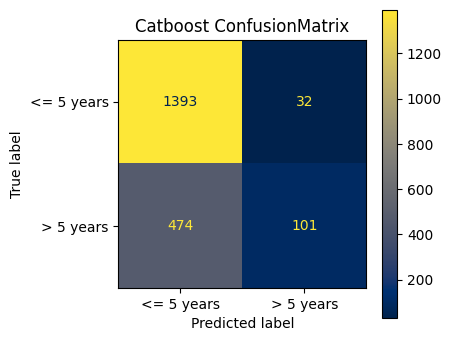

In [88]:
fig, ax = plt.subplots(figsize=(4,4))
cm = confusion_matrix(y_test, y_pred)
cm_cat = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=TARGET_LABELS
)
cm_cat.plot(cmap="cividis", ax=ax)
cm_cat.ax_.set_title("Catboost ConfusionMatrix")
fig.show()

In [89]:
df = pd.DataFrame(scores)
df #.to_csv('hyperparams_tuning.csv')

,model,train auc,val auc,accuracy,precision,f1_mean,recall,test auc
0,HistGradientBoostingClassifier,0.672323,0.638179,0.6810,0.450147,0.490415,0.538596,NaN
1,HistGradientBoostingClassifier,0.672323,NaN,0.6805,0.446667,0.456170,0.466087,0.616552
2,CatBoostClassifier,0.594276,0.576193,0.7455,0.707483,0.290098,0.182456,NaN
3,CatBoostClassifier,0.594276,NaN,0.7470,0.759398,0.285311,0.175652,0.576598


In [ ]:
# student = {
#     "sat_total_score": 1400,
#     "parental_level_of_education": "bachelor's degree",
#     "parental_income": 125000,
#     "college_gpa": 3.2
# }

Code block under Catboost heading saved as `'src/clf_histGradientBoost.py'`.
Code block under Catboost heading saved as `'src/clf_catboost.py'`.